In [30]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch 
import torch.nn as nn

from torch.optim import SGD
from torch.optim import Adam


import seaborn as sns
# import torchmetrics 

from torch.utils.data import DataLoader, Dataset
from pathlib import Path

In [2]:
# Gets the path of the data folder

data_path = Path(r"C:\Users\Brand\Documents\Branden's Stuff\Python\Machine Learning\data")
iris_path = data_path / "iris.data"

iris_data = pd.read_csv(iris_path)

# Preprocessing for labels
le = LabelEncoder()
iris_data["class"] = le.fit_transform(iris_data["class"])

In [3]:
iris_data

,sepal length in cm,sepal width in length,petal length in cm,petal width in cm,class
0,4.7,3.2,1.3,0.2,0
1,4.6,3.1,1.5,0.2,0
2,5.0,3.6,1.4,0.2,0
3,5.4,3.9,1.7,0.4,0
4,4.6,3.4,1.4,0.3,0
...,...,...,...,...,...
143,6.7,3.0,5.2,2.3,2
144,6.3,2.5,5.0,1.9,2
145,6.5,3.0,5.2,2.0,2
146,6.2,3.4,5.4,2.3,2


In [129]:
# Seperate the dataset for training and testing 
threshold = 0.6
y = iris_data["class"]
X = iris_data.drop(columns=["class"])

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.6, test_size=0.4, random_state=42)

pd.concat([X_train, y_train], axis=1)

,sepal length in cm,sepal width in length,petal length in cm,petal width in cm,class
44,5.1,3.8,1.6,0.2,0
15,5.1,3.5,1.4,0.3,0
101,6.3,2.9,5.6,1.8,2
39,4.5,2.3,1.3,0.3,0
68,5.9,3.2,4.8,1.8,1
...,...,...,...,...,...
71,6.1,2.8,4.7,1.2,1
106,6.7,2.5,5.8,1.8,2
14,5.4,3.9,1.3,0.4,0
92,5.6,2.7,4.2,1.3,1


### Custom Dataset
- The purpose of the custom dataset for PyTorch is to upload it into the dataloader
- Requires three methods to inherit **`__init__`**, **`__len__`**, **`__getitem__`**
<br> </br>
1. **__init__ `(Constructor)`**
    - Requires the data and if required, preprocess the data
    - Seperate the data into the features and the labels
    - Convert them into the approporate data types **`(floats or long)`**
    <br></br>
2. **__len__ `(Length)`**
    - Returns the length of the dataset
    <br></br>
3. **__getitem__ `(Index)`**
    - Returns the features and labels of the dataset at a specific index

In [18]:
class IrisFlowerDataset(Dataset):
    def __init__(self, X, y):
        self.df = X
        self.df_labels = y
        self.dataset = torch.tensor(self.df.to_numpy()).float()
        self.labels = torch.tensor(self.df_labels.to_numpy()).long()
    
    def __len__(self):
        return len(self.dataset)
        
    def __getitem__(self, i):
        return self.dataset[i], self.labels[i]


In [19]:
iris_train_dataset = IrisFlowerDataset(X_train, y_train)
iris_test_dataset = IrisFlowerDataset(X_test, y_test)

### Dataset Loader
- The purpose of dataset loader is to convert the dataset into mini batches
- Has many parameters to go over but **`num_workers`**, **`batch_size`**, **`drop_last`**, **`shuffle`** are some of the more important parameters
<br> </br>
1. **`num_workers`**
    - Increases the capacity of parallelism
    - The more workers there are, the faster the dataset is converted
    - However, this requires more memory to implement
    <br></br>
2. **`batch_size`**
    - Determines the size of each batch in the dataset
    <br></br>
3. **`shuffle`**
    - Shuffles the dataset before picking a data for its batches
    <br></br>
4. **`drop_last`**
    - Drops the batches that are not consistent with the batch size
    - Example: length of dataset is 130, want to create batch_size of 30, (30, 30, 30, 30, 10), results in the dropping of the batch_size of 10

In [56]:
train_dataloader = DataLoader(iris_train_dataset, batch_size=8, shuffle=True, drop_last=True)
test_dataloader = DataLoader(iris_test_dataset, batch_size=8, shuffle=True, drop_last=True)

train_feature, train_label = next(iter(train_dataloader))
train_feature.shape

torch.Size([8, 4])

In [110]:
class IrisModel(nn.Module):
    def __init__(self, input_shape, output_shape):
        super().__init__()
        self.hidden_layer = nn.Sequential(
            nn.Linear(input_shape, 20),
            nn.Dropout(p=0.5),
            nn.Linear(20, output_shape)
        )
        
    def forward(self, x):
        return self.hidden_layer(x)
    
iris_model = IrisModel(4, 3)

In [105]:
len(train_dataloader)

11

In [121]:
from tqdm.auto import tqdm

def train_test_process(model: nn.Module,
                      train_dataloader: DataLoader,
                      test_dataloader: DataLoader,
                      optimizer: SGD,
                      loss_fn: nn.CrossEntropyLoss,
                      epochs: int):
    
    test_accuracy_record = []
    
    for i in tqdm(range(epochs)):
        train_loss = 0
        model.train()
        
        for batch, (X,y) in enumerate(train_dataloader):
            y_pred = model(X)
            
            loss = loss_fn(y_pred, y)
            
            train_loss += loss
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        train_loss /= len(train_dataloader)
    
        model.eval()

        with torch.inference_mode():
            test_accuracy, test_loss = 0,0
            
            for X,y in test_dataloader:
                y_pred = model(X)

                test_loss += loss_fn(y_pred, y)
                test_accuracy += sum(y == y_pred.argmax(dim=-1)).numpy() / 8

            test_loss /= len(test_dataloader)
            test_accuracy /= len(test_dataloader) 

            test_accuracy_record.append(test_accuracy)
        if i % 100 == 0 or i == epochs - 1:
            print(f"EPOCH: {i} \nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_accuracy * 100:.2f}%\n")
    return test_accuracy_record

def predict(test_data, test_label, model):
    y_pred = model.forward(test_data).argmax(dim=-1)
    print(y_pred, test_label)
    

In [113]:
optimizer = SGD(iris_model.parameters(), lr=0.001)
# accuracy = Accuracy(task="multiclass", num_classes=len(train_data.classes))
cross_entropy_loss = nn.CrossEntropyLoss() 

EPOCHS = 1000

records = train_test_process(iris_model, train_dataloader, test_dataloader, optimizer, cross_entropy_loss, EPOCHS)

  0%|          | 0/1000 [00:00<?, ?it/s]

EPOCH: 0 
Train loss: 0.58559 | Test loss: 0.51118, Test acc: 98.21%

EPOCH: 10 
Train loss: 0.56035 | Test loss: 0.49674, Test acc: 92.86%

EPOCH: 20 
Train loss: 0.53817 | Test loss: 0.48007, Test acc: 94.64%

EPOCH: 30 
Train loss: 0.56320 | Test loss: 0.47172, Test acc: 92.86%

EPOCH: 40 
Train loss: 0.51319 | Test loss: 0.46118, Test acc: 94.64%

EPOCH: 50 
Train loss: 0.55337 | Test loss: 0.45337, Test acc: 94.64%

EPOCH: 60 
Train loss: 0.52308 | Test loss: 0.43372, Test acc: 94.64%

EPOCH: 70 
Train loss: 0.52344 | Test loss: 0.42988, Test acc: 94.64%

EPOCH: 80 
Train loss: 0.46299 | Test loss: 0.41231, Test acc: 96.43%

EPOCH: 90 
Train loss: 0.48415 | Test loss: 0.39845, Test acc: 96.43%

EPOCH: 100 
Train loss: 0.43999 | Test loss: 0.39778, Test acc: 94.64%

EPOCH: 110 
Train loss: 0.43332 | Test loss: 0.39951, Test acc: 94.64%

EPOCH: 120 
Train loss: 0.46183 | Test loss: 0.38756, Test acc: 94.64%

EPOCH: 130 
Train loss: 0.44895 | Test loss: 0.38609, Test acc: 96.43%

EPO

<AxesSubplot:>

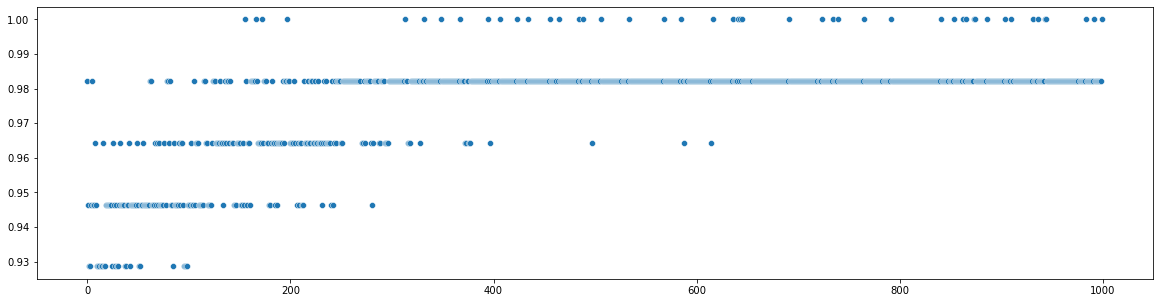

In [114]:
len(records)
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
sns.scatterplot(x=[i for i in range(len(records))], y=records)

In [134]:
predict(iris_test_dataset[1][0], iris_test_dataset[1][1], iris_model)



tensor(1) tensor(1)
